# Logistic Regression

Authors: 
- Max Ardito - maxwell.ardito@mail.mcgill.ca
- Edwin Meriaux - edwin.meriaux@mail.mcgill.ca
- Ohood Sabr - ohood.sabr@mail.mcgill.ca

# Regression Class

Class containing tools for a binary logistic regression

In [ ]:
import numpy as np
from numpy import log as ln
from enum import Enum
import math

"""
  Class for implementing a binary logistic regression. Includes additional
  functionality for penalizing weights using L1 and L2 regularization.

  Code citations: https://github.com/python-engineer/MLfromscratch
"""
class LogisticRegression:

    def __sigmoid(self, a: float):
        return (1 / (1 + np.exp(-a)))

    class Regularization(Enum):
        NONE = 0
        L1 = 1
        L2 = 2

    def __init__(self, step_size: float, iterations: int):
        self.step_size = step_size
        self.iterations = iterations

    def fit(self,
            X: np.ndarray,
            Y: np.ndarray,
            regularization: Regularization = Regularization.NONE,
            lmda: float = 0):
        # Initialize random weights and bias
        self.w = np.random.rand(X.shape[1])
        self.bias = np.random.rand()
        y_hat = np.ndarray(Y.shape)
        
        # Perform gradient descent
        for _ in range(self.iterations):
            wTx = np.dot(X, self.w) + self.bias
            y_hat = self.__sigmoid(wTx)

            # Implement a Lasso or Ridge regularization if specified
            if (regularization == self.Regularization.L1):
              dW = (1 / X.shape[0]) * np.add(np.dot(X.transpose(),
                                            (y_hat - Y.flatten())), np.dot(self.w, lmda * 2))
            elif (regularization == self.Regularization.L2):
              dW = (1 / X.shape[0]) * np.add(np.dot(X.transpose(),
                                            (y_hat - Y.flatten())), np.dot(self.w, np.sign(self.w) * lmda))
            else:
              dW = (1 / X.shape[0]) * np.dot(X.transpose(), (y_hat - Y.flatten()))
              
            dB = (1 / X.shape[0]) * np.sum(y_hat - Y.flatten())
            
            self.w -= self.step_size * dW
            self.bias -= self.step_size * dB
    
    def predict(self, X_new):
        #prediction of the LR model
        wTx = np.dot(X_new, self.w) + self.bias
        y_hat = self.__sigmoid(wTx)

        for i in range(y_hat.shape[0]):
            if y_hat[i] > 0.5:
                y_hat[i] = 1
            else:
                y_hat[i] = 0

        return y_hat


# Evaluation

Class containing various evaluation tools

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
""" 
    Class for evaluating the performance of a logistic regression model.
    Includes tools for calculating confusion matrix, accuracy, precision,
    recall, specificity, and false positive rate.

    Assumes that the input data is the result of a binary logistic regression
    (e.g. y && y_hat = {0, 1})
"""


class LogisticEvaluation:
    """ 
        Initializs the evaluation from a vector of predicted binary values (y)
        and a vector of actual values (y_hat). Stores these values in a 
        confusion matrix variable (cm) as well as individual cell 
        values (tp, tn, fp, fn)
    """

    def __init__(self, y_hat: np.ndarray, y: np.ndarray):
        size = y_hat.size
        self.cm = np.array([[0, 0], [0, 0]])
        for i in range(size):
            if (y_hat[i] == 1) and (y[i] == 1):
                self.cm += np.array([[1, 0], [0, 0]])
            elif (y_hat[i] == 0) and (y[i] == 0):
                self.cm += np.array([[0, 0], [0, 1]])
            elif (y_hat[i] == 1) and (y[i] == 0):
                self.cm += np.array([[0, 1], [0, 0]])
            else:
                self.cm += np.array([[0, 0], [1, 0]])
        # Normalize confusion matrix
        self.cm = np.divide(self.cm, np.array(size))

        # Store individual table values
        self.tp = self.cm[[0], [0]].item()
        self.tn = self.cm[[1], [1]].item()
        self.fp = self.cm[[1], [0]].item()
        self.fn = self.cm[[0], [1]].item()

    """ 
        Prints a heatmap of the confusion matrix 
    """

    def confusion_matrix(self):
        df = pd.DataFrame(self.cm)
        fig = plt.figure()
        cell_labels = np.array(
            [[
                "True Positive: " + str(round(self.tp, 2)),
                "False Positive: " + str(round(self.fp, 2))
            ],
             [
                 "False Negative: " + str(round(self.fn, 2)),
                 "True Negative: " + str(round(self.tn, 2))
             ]])
        print(round(self.tp, 2),round(self.fp, 2),round(self.fn, 2),round(self.tn, 2))

        sns.heatmap(df, fmt='', annot=cell_labels)
        plt.savefig("Heatmap.png")
        return self.cm

    """ 
        Returns the model's accuracy 
    """

    def accu_eval(self):
        accuracy = (self.tp + self.tn) / (self.cm.sum())
        return accuracy

    """ 
        Returns the model's precision 
    """

    def precision_eval(self):
        precision = self.tp / (self.tp + self.fp)
        return precision

    """ 
        Returns the model's recall 
    """

    def recall_eval(self):
        recall = self.tp / (self.tp + self.fn)
        return recall

    """ 
        Returns the model's specificity 
    """

    def spec_eval(self):
        specificity = self.tn / (self.fp + self.tn)
        return specificity

    """ 
        Returns the model's false positive rate 
    """

    def fpr_eval(self):
        fp_rate = self.fp / (self.fp + self.tn)
        return fp_rate


# K-Fold Cross Validation Class

Class that uses the logistic regression class in the context of a K-fold cross validation. Optional flags can be set for normalizing, expanding, and/or using the first N principal components to train instead of the features themselves

In [ ]:
import pandas as pd, numpy as np
from sklearn.preprocessing import StandardScaler
"""
        Class for performing K-fold cross validation and 
        returning its mean error. Ideally used for comparing 
        the performance of multiple logistic regression models.
"""


class KFold:
    """
        Initializes class by shuffling the input data and obtaining 
        a validation set size based on the input dimensions and specified 
        K value.

    """

    def __init__(self, 
                 X: np.ndarray, 
                 k: int, 
                 step_size: float,
                 iterations: int,
                 Normalization_toggle: int,
                 Regularization_toggle: int,
                 PCA_toggle: int, 
                 Expansion_toggle: int, 
                 pca_size: int,
                 broute_force_toggle: int):
        # Remove dupliacate data points
        self.X = np.unique(X, axis=0)
        self.k = k
        self.step_size = step_size
        self.iterations = iterations
        self.PCA_toggle = PCA_toggle
        self.Normalization_toggle = Normalization_toggle
        self.Regularization_toggle = Regularization_toggle
        self.Expansion_toggle = Expansion_toggle
        self.pca_size = pca_size
        self.brout_force_toggle = broute_force_toggle
        self.best_accuracy = 0
        self.best_combo = []

        # Validation size set = number of rows / k
        self.validation_set_size = int(self.X.shape[0] / k)

        # Shuffle the rows of the input data
        np.random.shuffle(self.X)

    """
       Performs the cross validation on K iterations of the input data.
       The cross validation is performed by taking the first validation 
       set from the top of the input data and then subsequently shifting 
       (rolling) the input data N elements, where N = validation set size.

       Note that this method of cycling and partitioning will automatically 
       throw any remainder of input data into the validation set if the data 
       set cannot be evenly divided into K sets.
    """
    #calculates variance and expectation based on np libraries
    def varience_expectation(self,Xdata):
      print(Xdata.shape[1])
      for i in range(Xdata.shape[1]):
          print("mean: ",np.mean(Xdata[i]))
          print("variance: ",np.var(Xdata[i]))
    
    #power set calculation for the brute for feature reduction
    #https://www.geeksforgeeks.org/power-set/ source used to help with the bit shift if statement
    def powerset(self,fullset):
      listsub = list(fullset)
      subsets = []
      for i in range(2**len(listsub)):
        subset = []
        for k in range(len(listsub)):            
          if i & 1<<k:
            subset.append(int(listsub[k]))
        subsets.append(subset)        
      return subsets

    #normalization calculation based on expectation (mu) and standard deviation (std)
    def normalization(self, Xtrain):
      normalized = Xtrain
      #operation on each feature in dataset
      #in theory this can be accelerated if a custom np function was used
      #would remove the need for the for loop
      #the function would effectively be everything in the current for loop
      for i in range(Xtrain.shape[1]):
        #mu calculation
        mu = np.sum(Xtrain[:,i])/Xtrain.shape[0]
        #std calculation
        std_subraction = np.subtract(Xtrain[:,i],mu)
        std_square = np.square(std_subraction)
        std_sum = np.sum (std_square)/Xtrain.shape[0]
        std = std_sum**(1/2)
        #normalization calculation
        normalized[:,i] = np.subtract(Xtrain[:,i],mu)/std
      
      return normalized

    # Principal Component Analysis function for dimensionality reduction
    # Code citation: https://www.askpython.com/python/examples/principal-component-analysis
    def PCA(self, X, num_components):
      # Center the data set by subtracting the mean
      X_mean = X - np.mean(X , axis = 0)
      
      # Get the covariance matrix
      covariance_matrix = np.cov(X_mean , rowvar = False)
      
      # Calculate the eigenvalues and eigenvectors of the covariance matrix
      eigen_values , eigen_vectors = np.linalg.eigh(covariance_matrix)
      
      # Sort the eigenvalues and eigenvectors in descending order
      sorted_index = np.argsort(eigen_values)[::-1]
      sorted_eigenvalue = eigen_values[sorted_index]
      sorted_eigenvectors = eigen_vectors[:,sorted_index]
      
      # Take a subset of the sorted vectors to represent the first N principal components
      eigenvector_subset = sorted_eigenvectors[:,0:num_components]
      
      # Reduce dimensionality by taking the dot product of the transposed
      # principal components mean of the original data set
      X_reduced = np.dot(eigenvector_subset.transpose(), X_mean.transpose()).transpose()
      
      return X_reduced
    
    #power calculation for feature expansion for which ever power needed ^2 ^3...
    def to_power(self, data, power):
      return data ** power
    
    #power log calculation for the features expansion
    def natural_log(self, data):
      math.log1p(data)
      return math.log1p(data)
    
    #mean feature decrease calculation to find the importance of each feature
    def feature_importance(self,X_train,Y_train):
      
      iterations = 10000
      learning_rate = 0.0015
      
      #setting up the baseline for the test results assuming all features tested on
      W, B, true_cost_list, true_accuracy, true_confusion = model(X_train, Y_train, learning_rate = learning_rate, iterations = iterations)
      feature_number_list = [i for i in range(X_train.shape[1])]
      
      #data storage for feature drop comparision
      importance_accuracy = []
      importance_confusion = []
      importance_cost = []
      for i in range(X_train.shape[1]):
          #runs test on each set of features. Set of features being n-1 features of n combinations
          tmp_list = feature_number_list
          tmp_list.remove(i)
          tmp_array = X_train[:,tmp_list]
          #current Logitic Regression test with modified dataset (see line above)
          W, B, cost_list, accuracy, confusion = model(tmp_array, Y_train, learning_rate = learning_rate, iterations = iterations)
          
          #data storage for future plots
          importance_accuracy.append(true_accuracy - accuracy)
          importance_confusion.append(confusion)
          importance_cost.append(cost_list)
          print(true_accuracy - accuracy)
      print(importance_accuracy)
      return importance_accuracy #data return

    #plotting mean feature decrease data
    def plot_results(self,data,val_list):
      plt.title("Air Quality Data Importance") #line changed depending on the data being run for feature decrease
      plt.bar(val_list,data)
      plt.show()

    #feature expansion for the data set to certain powers
    # powers: 2,3,1/2,1/3 and natural log
    def Feature_Increase(self, xdata):
      new_xdata = xdata
      for i in range(xdata.shape[1]):
          #higher exponential powers
          for j in range(2,4):
              tmp = xdata[:,i]
              tmp_vector = np.vectorize(self.to_power)
              tmp = np.asmatrix(tmp_vector(tmp,j))
              new_xdata = np.hstack((new_xdata, tmp.T))
          #1/n power of exponential powers
          for j in range(2,4):
              tmp = xdata[:,i]
              tmp_vector = np.vectorize(self.to_power)
              tmp = np.asmatrix(tmp_vector(tmp,1/j))
              new_xdata = np.hstack((new_xdata, tmp.T))
          #natural log power
          tmp = xdata[:,i]
          tmp_vector = np.vectorize(self.natural_log)
          tmp = np.asarray(tmp_vector(tmp))
          tmp = np.asmatrix(tmp)
          
          new_xdata = np.hstack((new_xdata, tmp.T))
      print(new_xdata)
      print(new_xdata.shape)
      return new_xdata.real

    def cross_validation(self):
        # Initialize error count
        self.train_err = 0
        self.test_err = 0

        # Separate the data's classes (Y) from the features (X)
        # and use expansion, normalization, and/or PCA if flags are set
        self.Y = np.array([self.X[:, -1]]).transpose()
        self.X = self.X[:, :-1]
        if self.Expansion_toggle == 1:
          self.X = self.Feature_Increase(self.X)
          self.X = np.asarray(self.X)
        if self.Normalization_toggle == 1:
          self.X = self.normalization(self.X)
        if self.PCA_toggle == 1:
          self.X = self.PCA(self.X,self.pca_size)
        if self.brout_force_toggle == 1:
          print(self.X.shape[1])
          print(list(range(self.X.shape[1])))
          test_set = self.powerset(list(range(self.X.shape[1])))
          
          for combo in test_set:
            print("____________")
            print("current combo: ",combo)
            print("best combo:", self.best_combo)
            print("best acc:", self.best_accuracy)
            print("____________")
            for i in range(self.k):
              tmpX = self.X[:,combo]
                          # Training set = all rows where index is larger than validation set size
              X_train = tmpX[self.validation_set_size:, :]
              Y_train = self.Y[self.validation_set_size:, :]

              # Test set = all rows where index is below validation set size
              X_test = tmpX[:self.validation_set_size, :]
              Y_test = self.Y[:self.validation_set_size, :]

              # Initialize logistic regression class for training data
              logistic = LogisticRegression(self.step_size, self.iterations)

              # Fit the model (get Ws)
              if (self.Regularization_toggle == 2):
                logistic.fit(X_train, Y_train, logistic.Regularization.L2, 0.001)
              elif (self.Regularization_toggle == 1):
                logistic.fit(X_train, Y_train, logistic.Regularization.L2, 0.001)
              else:
                logistic.fit(X_train, Y_train)

              # Predict Y ouput on X training data to measure accuracy
              Y_hat_train = logistic.predict(X_train)

              # Predict Y output on X test data
              Y_hat_test = logistic.predict(X_test)

              # Evaluate the predicted Y with the actual Y from the training data
              self.train_eval = LogisticEvaluation(
                  Y_hat_train, Y_train)

              # Evaluate the predicted Y with the actual Y from the test data
              self.test_eval = LogisticEvaluation(Y_hat_test, Y_test)

              # Accumulate the error
              self.train_err += self.train_eval.accu_eval()
              self.test_err += self.test_eval.accu_eval()

              print("Fold - ", i + 1, " / ", self.k)

              acc_train = self.train_eval.accu_eval() * 100
              acc_test = self.test_eval.accu_eval() * 100

              print("Accuracy (Training Data): ", float(f'{acc_train:.2f}'), "%")
              print("Accuracy (Validation Data): ", float(f'{acc_test:.2f}'),
                    "%")
              if acc_train > self.best_accuracy:
                self.best_accuracy = acc_train
                self.best_combo = combo

              # Shift the X data over a validation set size to ensure a new
              # validation set data for the next training iteration
              tmpX = np.roll(tmpX, -self.validation_set_size, axis=0)
              self.Y = np.roll(self.Y, -self.validation_set_size, axis=0)

        
        if self.brout_force_toggle == 0:

          # Train on training set, test on validation set
          for i in range(self.k):
              # Training set = all rows where index is larger than validation set size
              X_train = self.X[self.validation_set_size:, :]
              Y_train = self.Y[self.validation_set_size:, :]

              # Test set = all rows where index is below validation set size
              X_test = self.X[:self.validation_set_size, :]
              Y_test = self.Y[:self.validation_set_size, :]

              # Initialize logistic regression class for training data
              logistic = LogisticRegression(self.step_size, self.iterations)

              # Fit the model (get Ws)
              if(self.Regularization_toggle):
                logistic.fit(X_train, Y_train, logistic.Regularization.L2, 0.001)
              else:
                logistic.fit(X_train, Y_train)

              # Predict Y ouput on X training data to measure accuracy
              Y_hat_train = logistic.predict(X_train)

              # Predict Y output on X test data
              Y_hat_test = logistic.predict(X_test)

              # Evaluate the predicted Y with the actual Y from the training data
              self.train_eval = LogisticEvaluation(
                  Y_hat_train, Y_train)

              # Evaluate the predicted Y with the actual Y from the test data
              self.test_eval = LogisticEvaluation(Y_hat_test, Y_test)

              # Accumulate the error
              self.train_err += self.train_eval.accu_eval()
              self.test_err += self.test_eval.accu_eval()

              print("Fold - ", i + 1, " / ", self.k)

              acc_train = self.train_eval.accu_eval() * 100
              acc_test = self.test_eval.accu_eval() * 100

              print("Accuracy (Training Data): ", float(f'{acc_train:.2f}'), "%")
              print("Accuracy (Validation Data): ", float(f'{acc_test:.2f}'),
                    "%")

              # Shift the X data over a validation set size to ensure a new
              # validation set data for the next training iteration
              self.X = np.roll(self.X, -self.validation_set_size, axis=0)
              self.Y = np.roll(self.Y, -self.validation_set_size, axis=0)

        # Normalize error of all iterations of the validation set
        self.train_err /= self.k
        self.test_err /= self.k

        print("--------------------------------------------")

        total_acc_train = self.train_err * 100
        total_acc_test = self.test_err * 100

        print("Total Accuracy (Training Data): ",
              float(f'{total_acc_train:.2f}'), "%")
        print("Total Accuracy (Validation Data): ",
              float(f'{total_acc_test:.2f}'), "%")
        
        print("Confusion matrix for final fold: ")
        self.train_eval.confusion_matrix()
        return(total_acc_test)


# File Upload

Here you can upload the CSV you intend to use for the rest of the notebook. 


NOTE: Running these cells prompts you to upload a CSV files. Choose the original `air_quality.csv` or `liver_disease.csv` files. Be sure to replace the filename in the `io.BytesIO` function with the name of the file you intend to upload 👽


In [ ]:
#importing data from either google collab or locally
import io
from google.colab import files, drive

uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['air_quality.csv']))
data = df.to_numpy()

Saving air_quality.csv to air_quality.csv


# Dataset Analysis

Before training our various models, let's analyze the dataset a little bit with some helpful plots... The graphs below were generated using seaborn and matplotlib

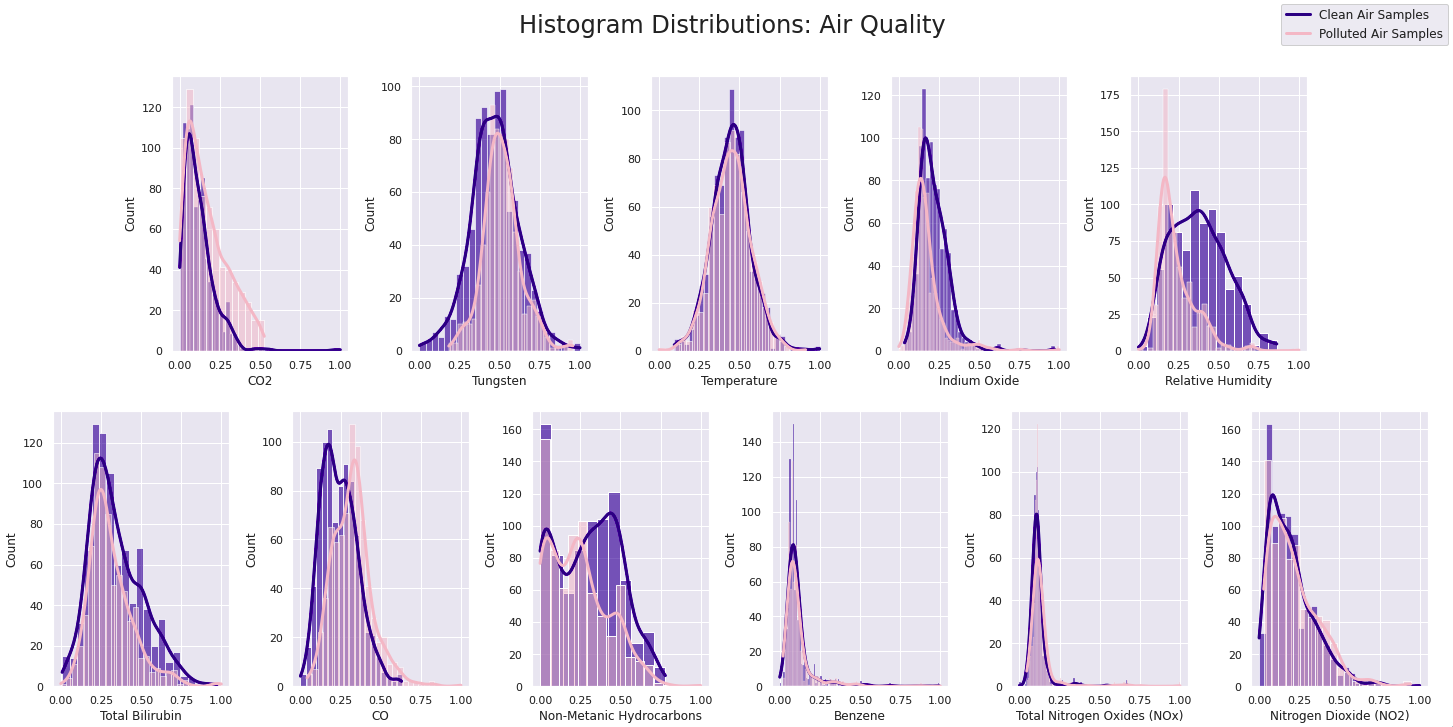
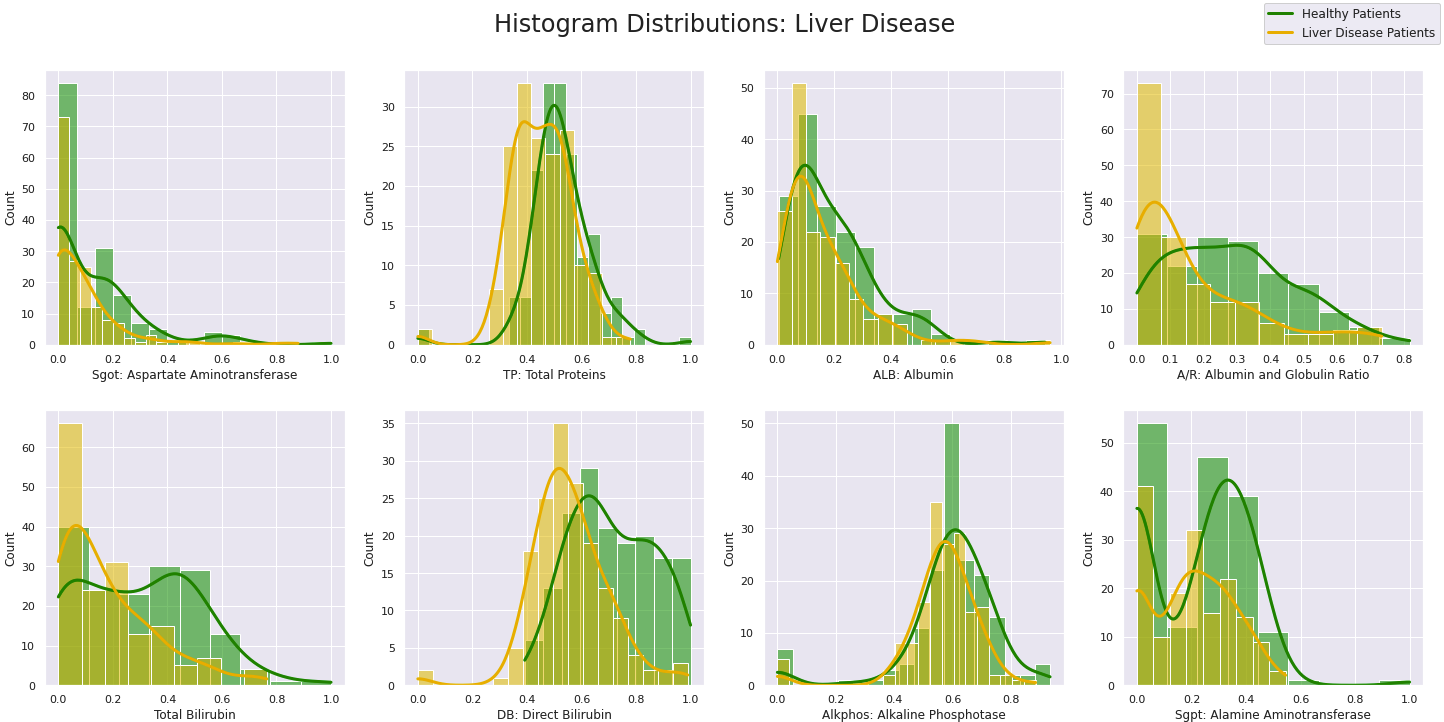

# Main Program - Base Model

Get air quality / liver patient data and run the regression using 10-fold cross validation


Fold -  1  /  10
Accuracy (Training Data):  73.74 %
Accuracy (Validation Data):  65.62 %
Fold -  2  /  10
Accuracy (Training Data):  73.74 %
Accuracy (Validation Data):  68.75 %
Fold -  3  /  10
Accuracy (Training Data):  73.74 %
Accuracy (Validation Data):  65.62 %
Fold -  4  /  10
Accuracy (Training Data):  74.41 %
Accuracy (Validation Data):  68.75 %
Fold -  5  /  10
Accuracy (Training Data):  72.05 %
Accuracy (Validation Data):  78.12 %
Fold -  6  /  10
Accuracy (Training Data):  72.05 %
Accuracy (Validation Data):  84.38 %
Fold -  7  /  10
Accuracy (Training Data):  75.08 %
Accuracy (Validation Data):  62.5 %
Fold -  8  /  10
Accuracy (Training Data):  74.75 %
Accuracy (Validation Data):  65.62 %
Fold -  9  /  10
Accuracy (Training Data):  74.07 %
Accuracy (Validation Data):  71.88 %
Fold -  10  /  10
Accuracy (Training Data):  72.73 %
Accuracy (Validation Data):  81.25 %
--------------------------------------------
Total Accuracy (Training Data):  73.64 %
Total Accuracy (Validati

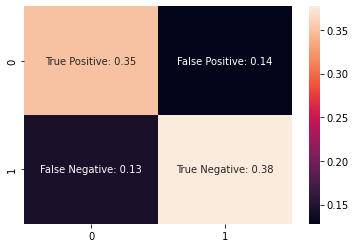

In [ ]:
import pandas as pd, numpy as np

def main():
    
    # Hyperparameters
    step_size = 0.001
    iterations = 100000
    folds = 10
    normalization = 1
    regularization = 1
    pca = 0
    expansion = 0
    brute_force = 0
    
    # Trains the model with no additional techniques using 10-fold cross validation
    k = KFold(data, 
              folds, 
              step_size, 
              iterations, 
              normalization, 
              regularization, 
              pca, 
              expansion, 
              8,
              brute_force)
    
    acc = k.cross_validation()
      
      
    print("________________________________")
    print("Total Accuracy: ", acc)
    print("________________________________")


if __name__ == "__main__":
    main()

# Main Program - Optimal Normalized Model

Below is the optimal model discussed in the report: a variation on the base model using a normalization step implemented on the dataset before training, afeature reduction, a feature expansion, and 11 different PCA sets cross-validated with each other using 10-fold.

Fold -  1  /  10
Accuracy (Training Data):  74.26 %
Accuracy (Validation Data):  77.04 %
Fold -  2  /  10
Accuracy (Training Data):  74.35 %
Accuracy (Validation Data):  74.07 %
Fold -  3  /  10
Accuracy (Training Data):  74.84 %
Accuracy (Validation Data):  71.11 %
Fold -  4  /  10
Accuracy (Training Data):  75.25 %
Accuracy (Validation Data):  67.41 %
Fold -  5  /  10
Accuracy (Training Data):  73.12 %
Accuracy (Validation Data):  77.78 %
Fold -  6  /  10
Accuracy (Training Data):  74.43 %
Accuracy (Validation Data):  74.81 %
Fold -  7  /  10
Accuracy (Training Data):  74.51 %
Accuracy (Validation Data):  72.59 %
Fold -  8  /  10
Accuracy (Training Data):  74.51 %
Accuracy (Validation Data):  71.11 %
Fold -  9  /  10
Accuracy (Training Data):  74.02 %
Accuracy (Validation Data):  75.56 %
Fold -  10  /  10
Accuracy (Training Data):  73.69 %
Accuracy (Validation Data):  77.78 %
--------------------------------------------
Total Accuracy (Training Data):  74.3 %
Total Accuracy (Validati

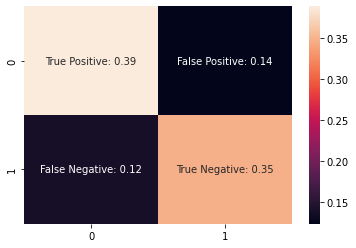

In [ ]:
import pandas as pd, numpy as np

def main():
    # Hyperparameters
    step_size = 0.001 #step sizes on the gradient descent
    iterations = 100000 #max epoch count of the test
    folds = 10 #number of folds on the kfolds
    normalization = 1 #normalization enabling bit (1 = active, 0 = inactive)
    regularization = 0 #regularization enabling bit (2 = active L2 regularization, 1 = active L1 regularization, 0 = inactive)
    pca = 1 #pca enabling bit (1 = active, 0 = inactive)
    pca_size = 11 #initiates the size of the pca set
    expansion = 1 #expansion enabling bit (1 = active, 0 = inactive)
    brute_force = 0 #brute_force enabling bit (1 = active, 0 = inactive)
    

    # Trains the model with no additional techniques using 10-fold cross validation
    k = KFold(data, 
              folds, 
              step_size, 
              iterations, 
              normalization, 
              regularization,
              pca, 
              expansion, 
              pca_size,
              brute_force)
    
    acc = k.cross_validation()
      
      
    print("________________________________")
    print("Total Accuracy: ", acc)
    print("________________________________")


if __name__ == "__main__":
    main()

# Main Program - Optimal Model with Regularization

## L2 Regularization

Below is the same model from above with an additional L2 Regularization implemented using a lambda value of `0.001`

Fold -  1  /  10
Accuracy (Training Data):  73.45 %
Accuracy (Validation Data):  75.56 %
Fold -  2  /  10
Accuracy (Training Data):  74.51 %
Accuracy (Validation Data):  74.07 %
Fold -  3  /  10
Accuracy (Training Data):  74.43 %
Accuracy (Validation Data):  74.81 %
Fold -  4  /  10
Accuracy (Training Data):  74.92 %
Accuracy (Validation Data):  68.15 %
Fold -  5  /  10
Accuracy (Training Data):  74.59 %
Accuracy (Validation Data):  71.85 %
Fold -  6  /  10
Accuracy (Training Data):  73.94 %
Accuracy (Validation Data):  77.78 %
Fold -  7  /  10
Accuracy (Training Data):  73.86 %
Accuracy (Validation Data):  77.78 %
Fold -  8  /  10
Accuracy (Training Data):  74.59 %
Accuracy (Validation Data):  71.85 %
Fold -  9  /  10
Accuracy (Training Data):  74.51 %
Accuracy (Validation Data):  72.59 %
Fold -  10  /  10
Accuracy (Training Data):  74.67 %
Accuracy (Validation Data):  69.63 %
--------------------------------------------
Total Accuracy (Training Data):  74.35 %
Total Accuracy (Validat

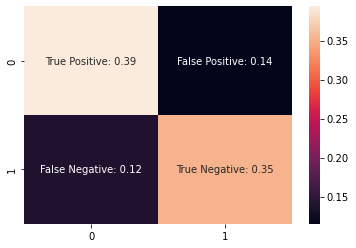

In [ ]:
import pandas as pd, numpy as np

def main():
    # Hyperparameters
    step_size = 0.001 #step sizes on the gradient descent
    iterations = 100000 #max epoch count of the test
    folds = 10 #number of folds on the kfolds
    normalization = 1 #normalization enabling bit (1 = active, 0 = inactive)
    regularization = 2 #regularization enabling bit (2 = active L2 regularization, 1 = active L1 regularization, 0 = inactive)
    pca = 1 #pca enabling bit (1 = active, 0 = inactive)
    pca_size = 11 #initiates the size of the pca set
    expansion = 1 #expansion enabling bit (1 = active, 0 = inactive)
    brute_force = 0 #brute_force enabling bit (1 = active, 0 = inactive)

    # Trains the model with no additional techniques using 10-fold cross validation
    k = KFold(data, 
              folds, 
              step_size, 
              iterations, 
              normalization, 
              regularization,
              pca, 
              expansion, 
              pca_size,
              brute_force)
    
    acc = k.cross_validation()
      
      
    print("________________________________")
    print("Total Accuracy: ", acc)
    print("________________________________")


if __name__ == "__main__":
    main()

## L1 Regularization

Here we attempt an L1 regularization on the optimal model, which should help limit the influence of unnecessary features

Fold -  1  /  10
Accuracy (Training Data):  73.77 %
Accuracy (Validation Data):  77.78 %
Fold -  2  /  10
Accuracy (Training Data):  74.59 %
Accuracy (Validation Data):  73.33 %
Fold -  3  /  10
Accuracy (Training Data):  73.94 %
Accuracy (Validation Data):  71.11 %
Fold -  4  /  10
Accuracy (Training Data):  74.75 %
Accuracy (Validation Data):  71.85 %
Fold -  5  /  10
Accuracy (Training Data):  74.35 %
Accuracy (Validation Data):  74.81 %
Fold -  6  /  10
Accuracy (Training Data):  74.35 %
Accuracy (Validation Data):  76.3 %
Fold -  7  /  10
Accuracy (Training Data):  73.53 %
Accuracy (Validation Data):  80.0 %
Fold -  8  /  10
Accuracy (Training Data):  74.51 %
Accuracy (Validation Data):  70.37 %
Fold -  9  /  10
Accuracy (Training Data):  74.26 %
Accuracy (Validation Data):  73.33 %
Fold -  10  /  10
Accuracy (Training Data):  74.18 %
Accuracy (Validation Data):  71.85 %
--------------------------------------------
Total Accuracy (Training Data):  74.22 %
Total Accuracy (Validatio

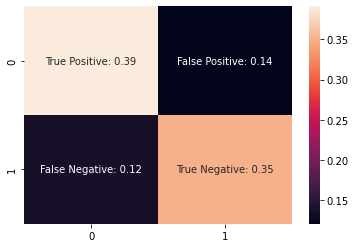

In [ ]:
import pandas as pd, numpy as np

def main():
    # Hyperparameters
    step_size = 0.001 #step sizes on the gradient descent
    iterations = 100000 #max epoch count of the test
    folds = 10 #number of folds on the kfolds
    normalization = 1 #normalization enabling bit (1 = active, 0 = inactive)
    regularization = 1 #regularization enabling bit (2 = active L2 regularization, 1 = active L1 regularization, 0 = inactive)
    pca = 1 #pca enabling bit (1 = active, 0 = inactive)
    pca_size = 11 #initiates the size of the pca set
    expansion = 1 #expansion enabling bit (1 = active, 0 = inactive)
    brute_force = 0 #brute_force enabling bit (1 = active, 0 = inactive)

    # Trains the model with no additional techniques using 10-fold cross validation
    k = KFold(data, 
              folds, 
              step_size, 
              iterations, 
              normalization, 
              regularization,
              pca, 
              expansion, 
              pca_size,
              brute_force)
    
    acc = k.cross_validation()
      
      
    print("________________________________")
    print("Total Accuracy: ", acc)
    print("________________________________")


if __name__ == "__main__":
    main()